# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [32]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on Colab

In [33]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [34]:
# import os
# if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
#     os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

In [35]:
!pip install gtts
!pip install wikipedia2vec==0.2.2
!pip install category-encoders
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install tensorflow-hub
!pip install tensorflow==2.1.0

  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=64c3b8ef6974ab72d70441cf83e5e94194bf068321845de27890eb55df653f87
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token
     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 276kB 17.9MB/s 
     |████████████████████████████████| 143kB 18.5MB/s 
  Created wheel for wikipedia2vec: filename=wikipedia2vec-0.2.2-cp36-cp36m-linux_x86_64.whl size=4423189 sha256=d1f34df2c2ce4980112ef261ee292c3214f9d091b54a933893c91fc27fc5ac25
  Stored in directory: /root/.cache/pip/wheels/bf/bc/96/1ac030513bf05d0d47d5dc6d194a73595dbcd7d1ff79145130
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp36-cp36m-linux_x86_64.whl size=861416 sha256=383fecd701c7ce9e5dba1561ce444f2a167c196b239871b268853c2f43bb66b4
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141a

In [36]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
        os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_nlp.txt') \
                     and os.path.exists(os.getcwd()+'/P6_functions.py')):
        print("ERROR: Make sure 'P6_functions.py' and \
'requirements_nlp.txt' are in the current working directory")

!pip install -r requirements_nlp.txt

In [37]:
from P6_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Installations (creating the requirements file)

In [38]:
# !pip freeze > requirements_nlp.txt

Importation of modules and packages. 

In [39]:
import io
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# import warnings
# warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Setting pandas display options.

In [40]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [41]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [42]:
speak('Packages and modules successfully imported')

### 0.1 Importing the datasets

Data is composed of 9 distinct .csv files we'll load in a dictionnary of dataframes.

In [43]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


In [44]:
speak('Datasets successfully imported')

## 1 Data extraction

### 1.1 Categories

Unfolding categories using the 'product_category_tree' colum

In [66]:
# sample checking
df['product_category_tree'][743]

'["Kitchen & Dining >> Containers & Bottles >> Bottles & Sippers >> Water bottle >> Nutcase Water bottle"]'

In [46]:
# determining the maximum tree depth of categories
ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [47]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df.index)

In [48]:
# printing number of categories in each level and a sample
display(df_cat_level.nunique(), df_cat_level.sample(3))

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
uniq_id,,,,,,
33d97d63c037078cd3f08033966d6a88,Watches,Watches/Wrist Watches,Watches/Wrist Watches/Ridas Wrist Watches,Watches/Wrist Watches/Ridas Wrist Watches/,Watches/Wrist Watches/Ridas Wrist Watches//,Watches/Wrist Watches/Ridas Wrist Watches///
e15195f2a5ebaa2168ccd65324e65e8e,Watches,Watches/Wrist Watches,Watches/Wrist Watches/Fluid Wrist Watches,Watches/Wrist Watches/Fluid Wrist Watches/,Watches/Wrist Watches/Fluid Wrist Watches//,Watches/Wrist Watches/Fluid Wrist Watches///
5dbf978ab2cf9d2da6446d3e4595f690,Kitchen & Dining,Kitchen & Dining/Coffee Mugs,Kitchen & Dining/Coffee Mugs/Printland Coffee Mugs,Kitchen & Dining/Coffee Mugs/Printland Coffee Mugs/,Kitchen & Dining/Coffee Mugs/Printland Coffee Mugs//,Kitchen & Dining/Coffee Mugs/Printland Coffee Mugs///


Let's see how much items are in each category

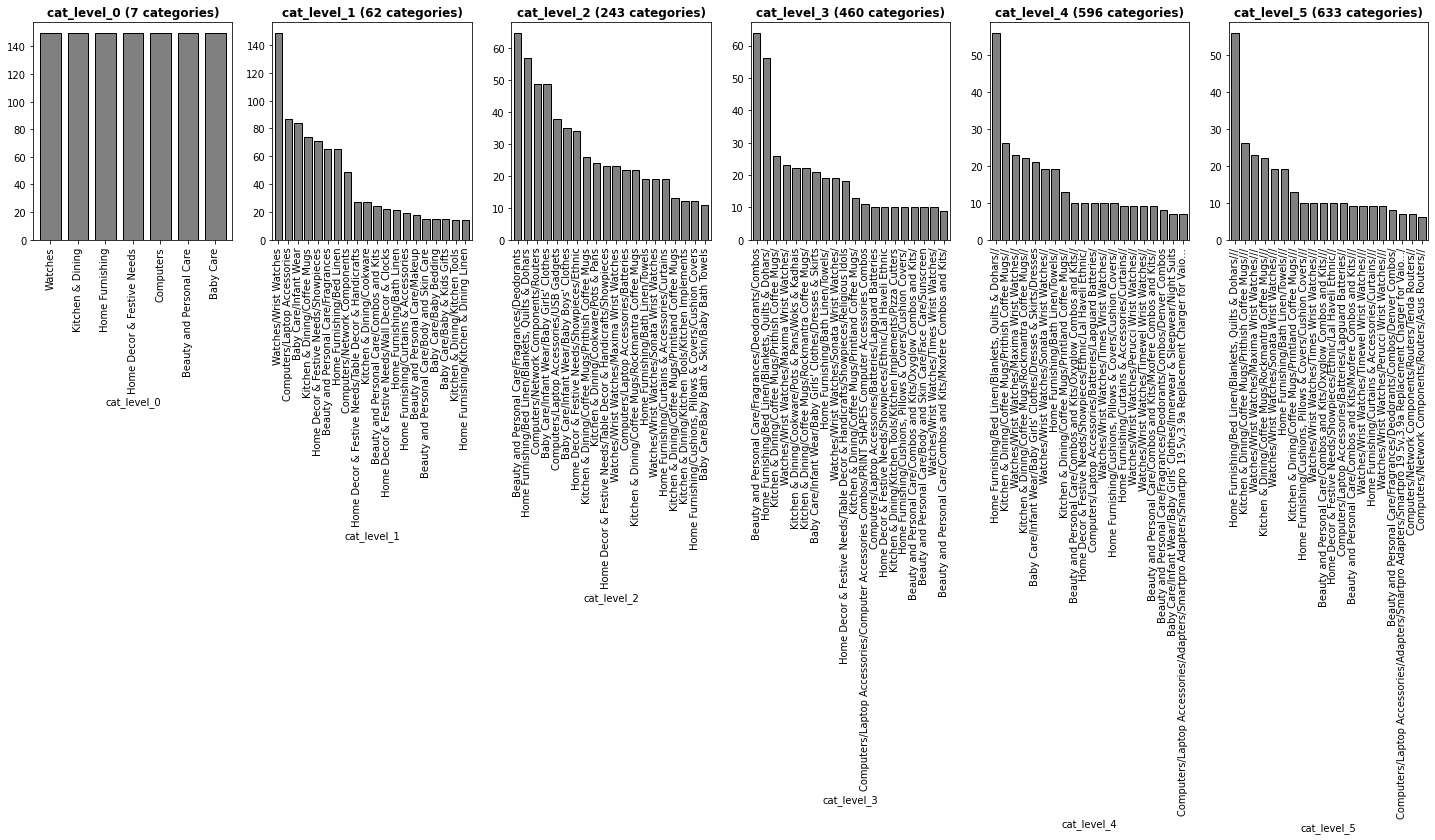

In [49]:
fig = plt.figure(figsize=(25,4))
for i, col in enumerate(df_cat_level.columns,1):
    ax = fig.add_subplot(1,len(df_cat_level.columns), i)
    ser = df_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:20].plot.bar(width=0.75, color='grey', ec='k', ax=ax)
    ax.set_title(col+f' ({ser.shape[0]} categories)', fontweight='bold')

The only level that has a balanced set of items is level 0, with 7 categories.
Let's rename these 7 categories:

In [50]:
df_cat_level['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [51]:
df_cat_level['category'] = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                        'Baby Care': 'Baby', 
                                        'Watches': 'Watches',
                                        'Home Decor & Festive Needs': 'Decor',
                                        'Kitchen & Dining': 'Kitchen',
                                        'Beauty and Personal Care': 'Beauty',
                                        'Computers': 'Computers'})

### 1.2 Products descriptions

In [52]:
# extracting only useful data
df_desc_cat = pd.concat([df_cat_level['category'],
                         df[["product_name", "description"]]], axis=1)

In [53]:
df_desc_cat.head()

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C..."


In [54]:
# creation of a corpus of all the descriptions
corpus = ' '.join(df_desc_cat['description'].values)
print("total nb of words in the whole corpus: ", len(corpus.split()))

total nb of words in the whole corpus:  80013


In [55]:
df_desc_cat

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C..."
...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n Price: Rs...
fd6cbcc22efb6b761bd564c28928483c,Baby,Wallmantra Large Vinyl Sticker Sticker,"Wallmantra Large Vinyl Sticker Sticker (Pack of 1)\r\n Price: Rs. 1,896\..."
5912e037d12774bb73a2048f35a00009,Baby,Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker,Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberly...


### 1.3 Global preprocessing

A first optimisation approach showed that some proprocessing steps are always beneficial to the models. We'll proceed to these steps before any further optimisation:
- lower case,
- keeping only alphabetic characters
- removing stopwords and single letters
- lemmatization
- keep only names and adjectives


In [56]:
# Stopwords and single letters
english_sw = nltk.corpus.stopwords.words('english')
single_let_sw = list(string.ascii_lowercase)
sw = list(set(english_sw + single_let_sw))

In [57]:
# Stemmer or lemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy

stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

These steps are embedded in the "tokenize_clean" function (see in "P6_functions.py" file)

In [58]:
#### Apply the transformations to descriptions and to product names

df_desc_cat['desc_clean'] = \
    df_desc_cat['description'].apply(lambda x: \
                                     tokenize_clean(x,
                                                    stopwords=sw,
                                                    keep_tags=['NN','JJ'],
                                                    stemmer=None,
                                                    lemmatizer=lemmatizer))\
                               .apply(lambda x: ' '.join(x))

df_desc_cat['pname_clean'] = \
    df_desc_cat['product_name'].apply(lambda x: \
                                     tokenize_clean(x,
                                                    stopwords=sw,
                                                    keep_tags=['NN','JJ'],
                                                    stemmer=None,
                                                    lemmatizer=lemmatizer))\
                              .apply(lambda x: ' '.join(x))

In [59]:
df_desc_cat.head(3)

,category,product_name,description,desc_clean,pname_clean
uniq_id,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",key elegance polyester multicolor abstract eyelet door floral curtain elegance polyester multico...,elegance polyester multicolor abstract eyelet door curtain
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",sathiyas cotton bath towel bath towel yellow blue bath towel machine washable material cotton de...,sathiyas cotton bath towel
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...",key eurospa cotton terry face towel size small height inch gsm eurospa cotton terry face towel p...,eurospa cotton terry face towel set


## 4 GridSearch optimization

#### Road map

We want to optimise the matching between the given categories ("true categories") and the clusters labels that can be found with unsupervised ML models.

The optimisation of the matching will be made using the v_measure metric using a custom GridSearch (GridSearchClust class in "P6_functions.py") adapted for clustering.

Various approaches will be tried for preprocessing and clustering:
- KMeans clustering of a simple document-terms matrix,
- Kmeans clustering of a document-term matrix (with dimensionality reduction prior to clustering)
- Main topic (*argmax()*) obtained by topics modelisation (LSA, NMF, LDA)
- Kmeans clustering on a matrix obtained using word or sentence embeddings technique

#### Metrics choice for optimization

The metrics we'll use for optimisation is v_measure defined as:

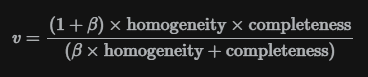

Where homogeneity and completeness are respectively:

Homogeneity and completeness scores are formally given by:

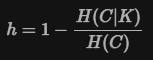 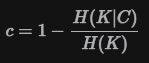

where  is the conditional entropy of the classes given the cluster assignments and is given by:

 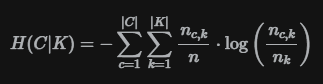
 
 
 
and  is the entropy of the classes and is given by:

 
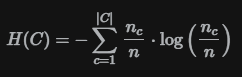 
 
with  the total number of samples, 
 and 
 the number of samples respectively belonging to class  and cluster , and finally  the number of samples from class  assigned to cluster .
 

**Bounded scores**: 0.0 is as bad as it can be, 1.0 is a perfect score.

**Intuitive interpretation**: clustering with bad V-measure can be qualitatively analyzed in terms of homogeneity and completeness to better feel what ‘kind’ of mistakes is done by the assignment.

**No assumption is made on the cluster structure**: can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

**Drawbacks**:

- The previously introduced metrics are not normalized with regards to random labeling: this means that depending on the number of samples, clusters and ground truth classes, a completely random labeling will not always yield the same values for homogeneity, completeness and hence v-measure. In particular random labeling won’t yield zero scores especially when the number of clusters is large.

- This problem can safely be ignored when the number of samples is more than a thousand and the number of clusters is less than 10. For smaller sample sizes or larger number of clusters it is safer to use an adjusted index such as the Adjusted Rand Index (ARI).

Importations

In [192]:
import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from nltk.stem.snowball import EnglishStemmer
import spacy

In [193]:
df_res_clust = pd.DataFrame()
df_res_clust['categories'] = df_desc_cat['category']

In [194]:
dict_best_df = {}

### 4.1 Optimize preprocessing (document-terms matrix) -> KMeans clustering

At first we'll try to find the simple document-terms matrix encoding that gives the best KMeans score.

The pipeline to be optimized has 2 steps:
- Custom NLP transformer (BOW or TFIDF matrix) with various options (binary, max_features, min_df, max_df etc.)
- KMeans clustering (7 categories)

In [195]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0, 0.05, 0.1],
              'custtrans__max_df': [0.13, 0.15, 1.0],
              'custtrans__max_features': [300,400,500,550,600,650,700,800,900],
              'custtrans__ngram_range': [(1,1), (1,2), (1,3)],
              'custtrans__binary': [False, True],
              'custtrans__tfidf_on': [False, True],
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.5, 0.6, 0.625, 0.65, 0.675, 0.7],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='v_meas',
                      greater_is_better=True) # for the refit_score

In [ ]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']],
        verbose=True);

 2813/5832:

In [ ]:
### Pickling the results
import dill as pickle
with open('01_gsc_preproc_km.pkl', 'wb') as file:
    pickle.dump(gsc, file)

In [89]:
# ### Loading the results
# import dill as pickle
# with open('01_gsc_preproc_km.pkl', 'rb') as file:
#     gsc = pickle.load(file)

In [90]:
gsc_res = gsc.results_

In [91]:
# Display results (products name) A REMPLACER
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
# -----Product name
# Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.15, 'custtrans__max_features': 600, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}
# Best refit score: 0.59550947497682

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.15, 'custtrans__max_features': 600, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}
Best refit score: 0.59550947497682


"-----Product name\nBest hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.15, 'custtrans__max_features': 600, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}\nBest refit score: 0.59550947497682"

Plotting the results of the clustering optimization

In [92]:
# Compute the dataframe showing the results depending on one parameter
#(other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc, 'custtrans__pname_weight',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.50,0.06,30.18,3.39,0.47,0.27,0.44,0.51,0.47
0.60,0.06,26.20,3.60,0.49,0.30,0.45,0.53,0.49
0.62,0.06,27.07,4.04,0.48,0.28,0.46,0.51,0.48
0.65,0.07,27.22,3.55,0.59,0.33,0.54,0.66,0.60
0.68,0.07,25.64,3.87,0.50,0.33,0.47,0.55,0.51
0.70,0.07,25.37,3.45,0.53,0.24,0.47,0.62,0.54


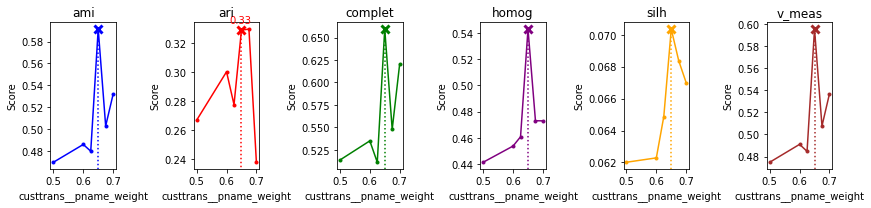

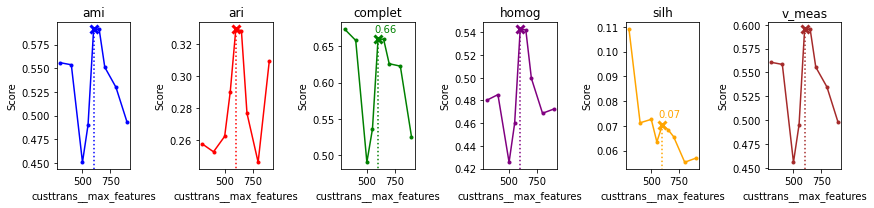

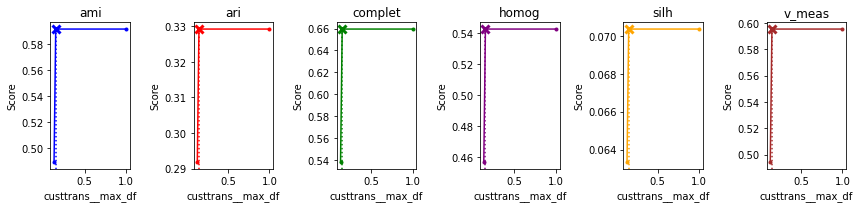

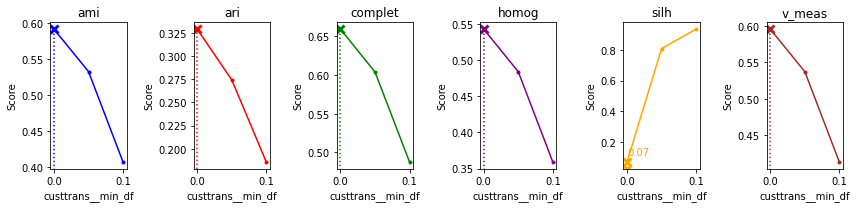

In [93]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_df', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__min_df', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

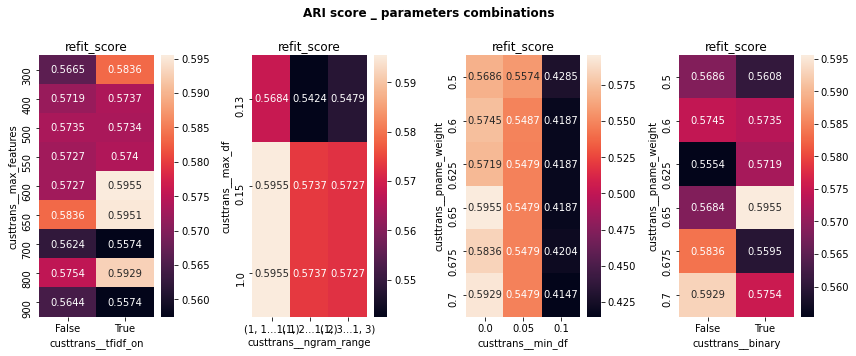

In [94]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__max_features', 'custtrans__tfidf_on']
params2 = ['custtrans__max_df', 'custtrans__ngram_range']
params3 = ['custtrans__pname_weight', 'custtrans__min_df']
params4 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,4,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,4,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,4,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

ax4 = fig.add_subplot(1,4,4)
plot_2D_gsclust_param_opt(gsc, params=params4, shorten_label=5, ax=ax4)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

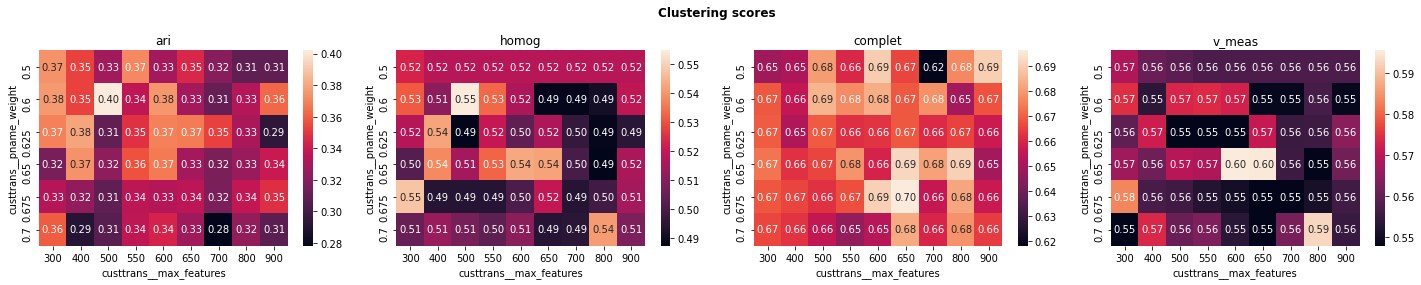

In [95]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['custtrans__pname_weight', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [96]:
# Storing labels of the best model in a dataframe
df_res_clust['01_preproc_km'] = \
                gsc.best_estimator_.predict(df_desc_cat[['desc_clean',
                                                        'pname_clean']])

In [97]:
# Computing the best preprocessed dataset prior to clustering
dict_best_df['01_preproc_km'] = \
        gsc.best_estimator_.transform(df_desc_cat[['desc_clean',
                                                   'pname_clean']])

In [98]:
### Pickling the best preprocessed dataset prior to clustering
import dill as pickle
with open('dict_best_df.pkl', 'wb') as file:
    pickle.dump(dict_best_df, file)

### 4.2 Optimize preprocessing (dimension reduction) -> KMeans clustering

Let's see if a dimensionality reduction over a document-terms matrix can give better KMeans score.

The pipeline to be optimized has 3 steps:
- Custom NLP transformer (BOW or TFIDF matrix) with various options (binary, max_features, min_df, max_df etc.)
- Dimensionality reduction
- KMeans clustering (7 categories)

In [ ]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('dimreduc', PCA()), # Dimensionality reduction 
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0],
              'custtrans__max_df': [1.0],
              'custtrans__max_features': [75,100,200,250,300,
                                          500,700,900],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [False, True],
              'custtrans__tfidf_on': [False, True],
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.4,0.6,0.625,0.65,0.675,0.7,0.9],
              'dimreduc': [
                           PCA(random_state=14), 
                           LDA(random_state=14),
                           NMF(random_state=14),
                           TruncatedSVD(random_state=14),
                           ], #[TSNE_wrapper(random_state=14), UMAP(random_state=14)],
              'dimreduc__n_components': [2,5,7,10,15,20,50,75],
            #   'svd__n_iter': [4,5,6],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

In [ ]:
### Pickling the results
import dill as pickle
with open('02_gsc_preproc_dimred_km.pkl', 'wb') as file:
    pickle.dump(gsc, file)

In [101]:
# ### Loading the results
# import dill as pickle
# with open('02_gsc_preproc_dimred_km.pkl', 'rb') as file:
#     gsc = pickle.load(file)

In [102]:
gsc_res = gsc.results_

In [103]:
# Display results (products name) A REMPLACER
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
# -----Product name
# Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': False, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 1.0, 'custtrans__max_features': 300, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': False, 'custtrans__w2v': None, 'dimreduc': LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#                           evaluate_every=-1, learning_decay=0.7,
#                           learning_method='batch', learning_offset=10.0,
#                           max_doc_update_iter=100, max_iter=10,
#                           mean_change_tol=0.001, n_components=100, n_jobs=None,
#                           perp_tol=0.1, random_state=14, topic_word_prior=None,
#                           total_samples=1000000.0, verbose=0), 'dimreduc__n_components': 10}
# Best refit score: 0.4689158879407379

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': False, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 1.0, 'custtrans__max_features': 300, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': False, 'custtrans__w2v': None, 'dimreduc': LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=100, n_jobs=None,
                          perp_tol=0.1, random_state=14, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0), 'dimreduc__n_components': 10}
Best refit score: 0.4689158879407379


"-----Product name\nBest hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': False, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 1.0, 'custtrans__max_features': 300, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': False, 'custtrans__w2v': None, 'dimreduc': LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,\n                          evaluate_every=-1, learning_decay=0.7,\n                          learning_method='batch', learning_offset=10.0,\n                          max_doc_update_iter=100, max_iter=10,\n                          mean_change_tol=0.001, n_components=100, n_jobs=None,\n                          perp_tol=0.1, random_state=14, topic_word_prior=None,\n                          total_samples=1000000.0, verbose=0), 'dimreduc__n_components': 10}\nBest refit score: 0.4689158879407379"

Plotting the results of the clustering optimization

In [104]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc, 'custtrans__pname_weight',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.50,0.56,443.85,1.01,0.51,0.41,0.50,0.52,0.51
0.60,0.54,406.66,1.06,0.50,0.40,0.49,0.51,0.50
0.62,0.54,413.87,1.06,0.50,0.41,0.50,0.51,0.50
0.65,0.54,385.51,1.14,0.53,0.47,0.53,0.54,0.53
0.68,0.55,418.65,1.02,0.50,0.40,0.49,0.51,0.50
0.70,0.55,407.29,0.99,0.47,0.36,0.46,0.49,0.48


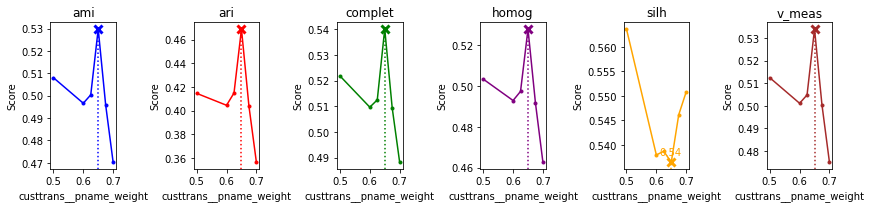

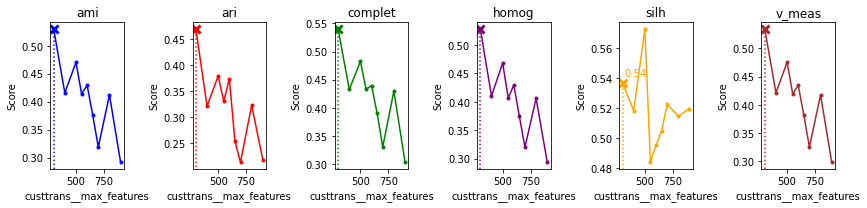

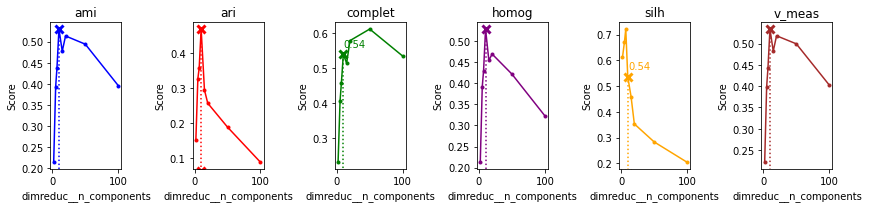

In [106]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

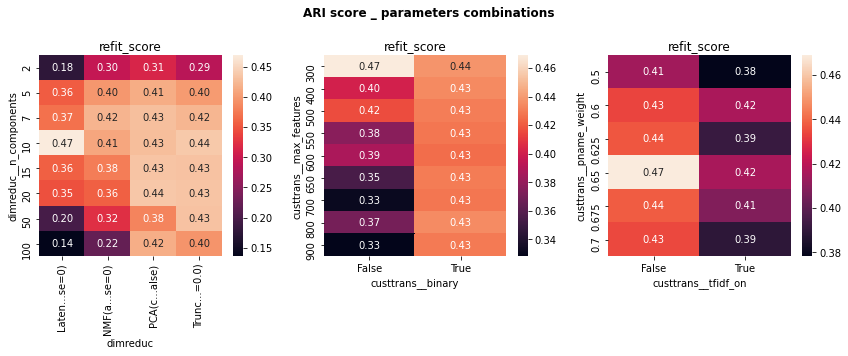

In [107]:
# Effect of 2 parameters on clustering scores

params1 = ['dimreduc__n_components', 'dimreduc']
params2 = ['custtrans__max_features', 'custtrans__binary']
params3 = ['custtrans__pname_weight', 'custtrans__tfidf_on']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, fmt='.2f',
                          shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, fmt='.2f',
                          shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, fmt='.2f',
                          shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

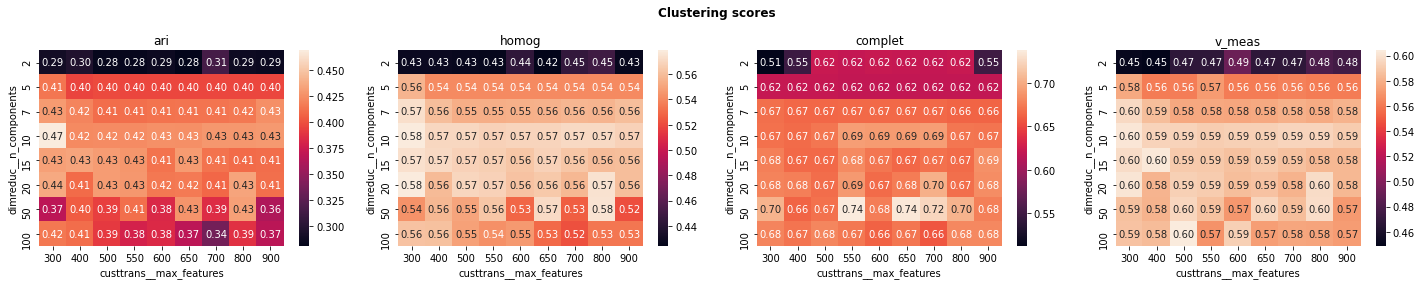

In [108]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['dimreduc__n_components', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [109]:
# Storing labels of the best model in a dataframe
df_res_clust['02_preproc_dimred_km'] = \
        gsc.best_estimator_.predict(df_desc_cat[['desc_clean',
                                                        'pname_clean']])

In [110]:
# Computing the best preprocessed dataset prior to clustering
dict_best_df['02_preproc_dimred_km'] = \
        gsc.best_estimator_.transform(df_desc_cat[['desc_clean',
                                                   'pname_clean']])

In [112]:
### Pickling the best preprocessed dataset prior to clustering
import dill as pickle
with open('dict_best_df.pkl', 'wb') as file:
    pickle.dump(dict_best_df, file)

### 4.3 Optimize preprocessing and choice of topics modelers

In [ ]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('clusterer', TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0], # [0,0.01, 0.02]
              'custtrans__max_df': [1.0], #[0.1,0.15,0.2,0.3]
              'custtrans__max_features': [20,50,100,125,150,175,200,
                                          250,300,400,500,750,1000,1500,2000],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True, False], # False
              'custtrans__tfidf_on': [True, False], # False
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.6,0.7,0.8,0.9,0.95],
              'clusterer__n_model': ['nmf', 'lda', 'lsa'],
              'clusterer__n_components': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

In [ ]:
### Pickling the results
import dill as pickle
with open('03_gsc_preproc_tm.pkl', 'wb') as file:
    pickle.dump(gsc, file)

In [ ]:
# ### Loading the results
# import dill as pickle
# with open('03_gsc_preproc_tm.pkl', 'rb') as file:
#     gsc = pickle.load(file)

In [124]:
gsc_res = gsc.results_

In [125]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)

# -----Product name
# Best hyperparameters: {'clusterer__n_components': 7, 'clusterer__n_model': 'nmf',
# 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None,
# 'custtrans__max_df': 0.5, 'custtrans__max_features': 127, 'custtrans__min_df': 0,
# 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.94, 'custtrans__stemmer': None,
# 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}
# Best refit score: 0.5536655788135667

-----Product name
Best hyperparameters: {'clusterer__n_components': 7, 'clusterer__n_model': 'nmf', 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 1.0, 'custtrans__max_features': 100, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.8, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}
Best refit score: 0.47979723580772404


Plotting the results of the clustering optimization

In [ ]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc, 'custtrans__pname_weight',
                                    return_df_res=True)
df_sel_scores

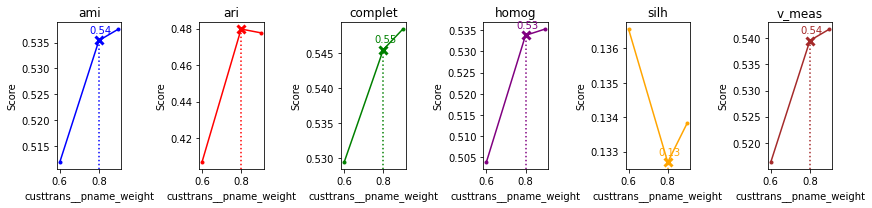

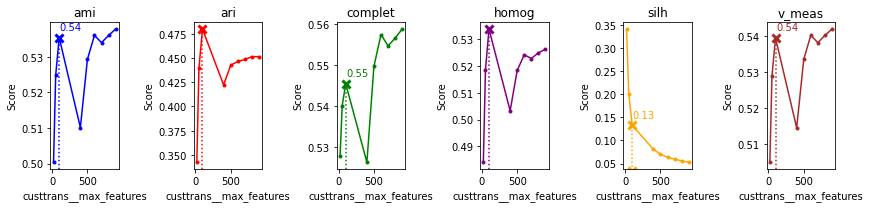

In [127]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

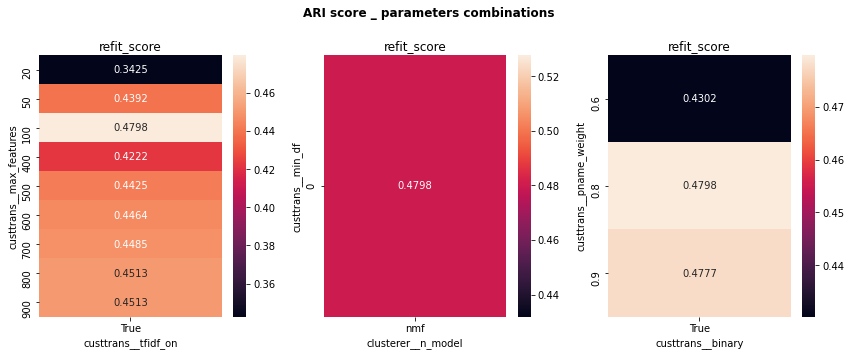

In [128]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__max_features', 'custtrans__tfidf_on']
params2 = ['custtrans__max_features', 'clusterer__n_model']
params3 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

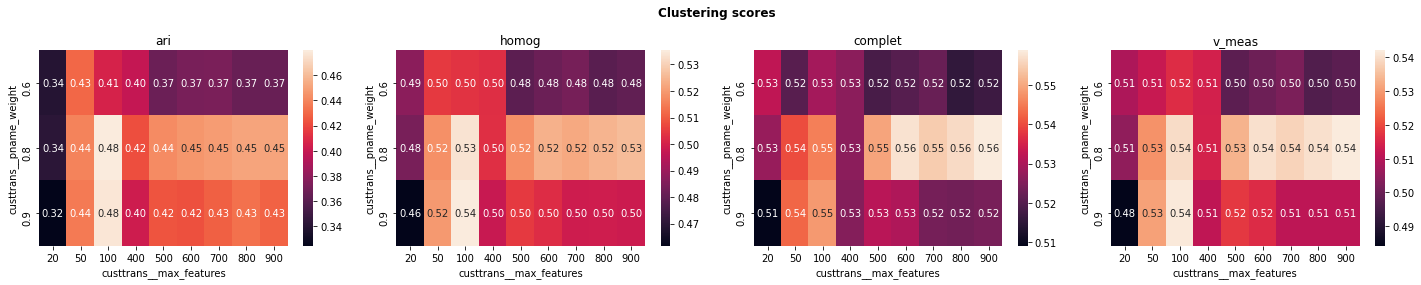

In [129]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['custtrans__pname_weight', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas'] # list(gsc.get_params()['scoring'])
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# Storing labels of the best model in a dataframe
df_res_clust['03_preproc_tm'] = \
                gsc.best_estimator_.predict(df_desc_cat[['desc_clean',
                                                        'pname_clean']])

In [ ]:
# Computing the best preprocessed dataset prior to clustering
dict_best_df['03_preproc_tm'] = \
        gsc.best_estimator_.transform(df_desc_cat[['desc_clean',
                                                   'pname_clean']])

In [ ]:
### Pickling the best preprocessed dataset prior to clustering
import dill as pickle
with open('dict_best_df.pkl', 'wb') as file:
    pickle.dump(dict_best_df, file)

### 4.4 Optimize preprocessing (pretrained word embeddings)

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 2 steps:
- Custom NLP transformer (BOW or TFIDF matrix)
- Clustering using topics modeling (7 topics)

#### Wiki2vec

In [ ]:
## Using a pretrained model
# https://wikipedia2vec.github.io/wikipedia2vec/pretrained/
from wikipedia2vec import Wikipedia2Vec
wiki2vec = Wikipedia2Vec.load("../DATA/enwiki_20180420_100d.pkl") # 100 dimensions

In [ ]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('custtrans', CustNLPTransformer()),# Custom NLP preprocessor
                 ('dimreduc', PCA(random_state=14)),
                 ('clusterer', KMeans(random_state=14)),#TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0],
              'custtrans__max_df': [1.0],
              'custtrans__max_features': [50,70,100,200,500],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True, False], # False
              'custtrans__tfidf_on': [True, False], # False
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.5,0.6,0.7,0.8,0.9],
              'dimreduc': [PCA(random_state=14), 
                           LDA(random_state=14),
                           NMF(random_state=14),
                           TruncatedSVD(random_state=14)],
              'dimreduc__n_components': [2,5,10,20,50],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True,
                      return_estimators=False)

In [ ]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

In [ ]:
### Pickling the results
import dill as pickle
with open('04a_gsc_preproc_dimreduc_w2v_km.pkl', 'wb') as file:
    pickle.dump(gsc, file)

In [ ]:
# ### Loading the results
# import dill as pickle
# with open('04a_gsc_preproc_dimreduc_w2v_km.pkl', 'rb') as file:
#     gsc = pickle.load(file)

In [156]:
gsc_res = gsc.results_

In [157]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_
# -----Product name
# Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.2, 'custtrans__max_features': 70, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.5, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': <wikipedia2vec.wikipedia2vec.Wikipedia2Vec object at 0x7fa00743fd18>}
# Best refit score: 0.42056239767415315

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 1.0, 'custtrans__max_features': 500, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.6, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': False, 'custtrans__w2v': None}
Best refit score: 0.4019957322565853


Plotting the results of the clustering optimization

In [ ]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc, 'custtrans__pname_weight',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.50,0.56,443.85,1.01,0.51,0.41,0.50,0.52,0.51
0.60,0.54,406.66,1.06,0.50,0.40,0.49,0.51,0.50
0.62,0.54,413.87,1.06,0.50,0.41,0.50,0.51,0.50
0.65,0.54,385.51,1.14,0.53,0.47,0.53,0.54,0.53
0.68,0.55,418.65,1.02,0.50,0.40,0.49,0.51,0.50
0.70,0.55,407.29,0.99,0.47,0.36,0.46,0.49,0.48


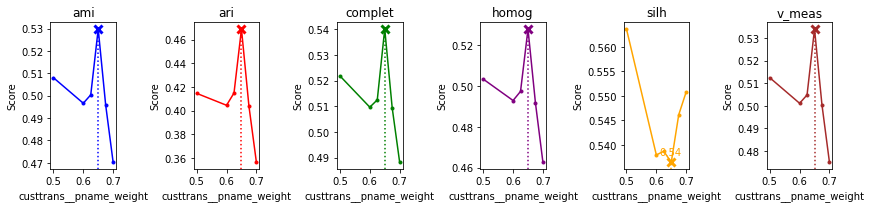

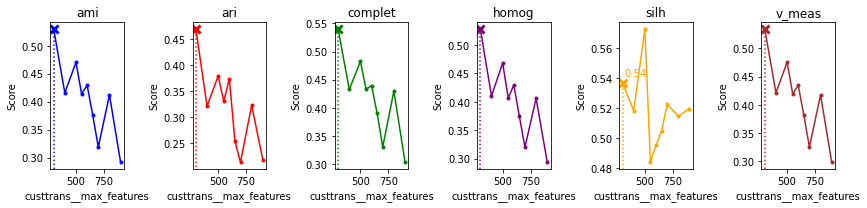

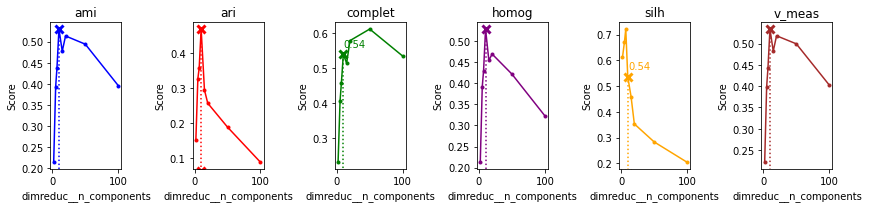

In [ ]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

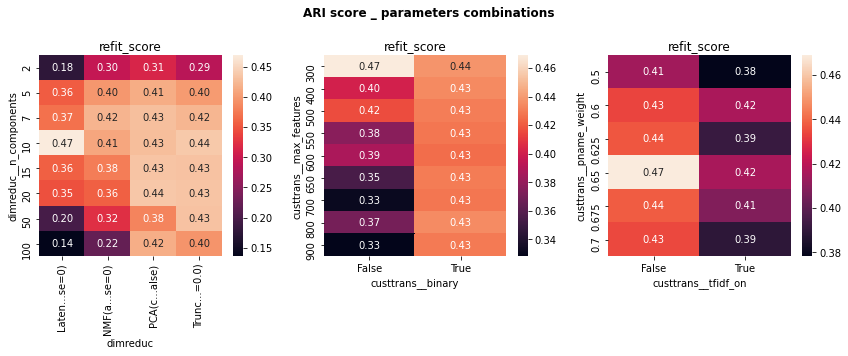

In [ ]:
# Effect of 2 parameters on clustering scores

params1 = ['dimreduc__n_components', 'dimreduc']
params2 = ['custtrans__max_features', 'custtrans__binary']
params3 = ['custtrans__pname_weight', 'custtrans__tfidf_on']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, fmt='.2f',
                          shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, fmt='.2f',
                          shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, fmt='.2f',
                          shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

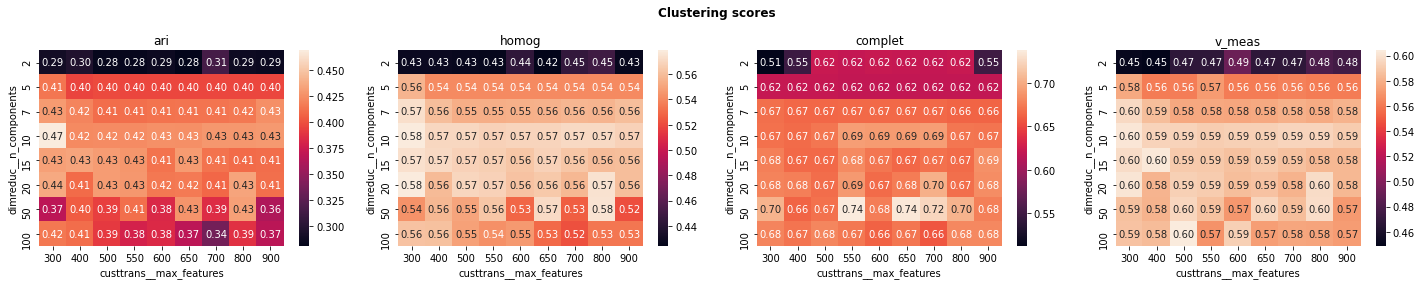

In [ ]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['dimreduc__n_components', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# Storing labels of the best model in a dataframe
df_res_clust['04a_gsc_preproc_dimreduc_w2v_km'] = \
        gsc.best_estimator_.predict(df_desc_cat[['desc_clean',
                                                        'pname_clean']])

In [ ]:
# Computing the best preprocessed dataset prior to clustering
dict_best_df['04a_gsc_preproc_dimreduc_w2v_km'] = \
        gsc.best_estimator_.transform(df_desc_cat[['desc_clean',
                                                   'pname_clean']])

In [ ]:
### Pickling the best preprocessed dataset prior to clustering
import dill as pickle
with open('dict_best_df.pkl', 'wb') as file:
    pickle.dump(dict_best_df, file)

#### Universal Sentence Encoder (USE)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# récuperer l'encodeur depuis le site de google
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [ ]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('dimreduc', PCA(random_state=14)),
                 ('clusterer', KMeans(random_state=14)),#TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'dimreduc': [PCA(random_state=14), 
                           LDA(random_state=14),
                           NMF(random_state=14),
                           TruncatedSVD(random_state=14)], #[TSNE_wrapper(random_state=14), UMAP(random_state=14)],
              'dimreduc__n_components': [2,5,10,20,50],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True,
                      return_estimators=True)

In [ ]:
# encoding each description
tf_tensor = encoder(df_desc_cat['description'].values)
# put in a dataframe
df_USE_desc = pd.DataFrame(tf.make_ndarray(tf.make_tensor_proto(tf_tensor)),
                            index=df_desc_cat['product_name'].index,
                            columns=['dim_'+str(i) for i in range(512)])

In [ ]:
# encoding each product_name
tf_tensor = encoder(df_desc_cat['product_name'].values)
# put in a dataframe
df_USE_pname = pd.DataFrame(tf.make_ndarray(tf.make_tensor_proto(tf_tensor)),
                            index=df_desc_cat['product_name'].index,
                            columns=['dim_'+str(i) for i in range(512)])

In [ ]:
##### Perform the grid search
gsc.fit(df_USE_pname, verbose=True);

In [ ]:
### Pickling the results
import dill as pickle
with open('04b_USEpname_dimred_km.pkl', 'wb') as file:
    pickle.dump(gsc, file)

In [ ]:
##### Perform the grid search
gsc.fit(df_USE_desc, verbose=True);

In [ ]:
### Pickling the results
import dill as pickle
with open('04b_USEdesc_dimred_km.pkl', 'wb') as file:
    pickle.dump(gsc, file)

In [ ]:
# ### Loading the results
# import dill as pickle
# with open('04b_USE_dimred_km.pkl', 'rb') as file:
#     gsc = pickle.load(file)

In [184]:
gsc_res = gsc.results_

In [185]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_
'''
-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'dimreduc': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=14,
             tol=0.0), 'dimreduc__n_components': 10}
Best refit score: 0.5675863555495734'''

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'dimreduc': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=14,
             tol=0.0), 'dimreduc__n_components': 10}
Best refit score: 0.5675863555495734


"-----Product name\nBest hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.2, 'custtrans__max_features': 70, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.5, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': <wikipedia2vec.wikipedia2vec.Wikipedia2Vec object at 0x7fa00743fd18>}\nBest refit score: 0.42056239767415315"

Plotting the results of the clustering optimization

In [ ]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc, 'custtrans__pname_weight',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.50,0.56,443.85,1.01,0.51,0.41,0.50,0.52,0.51
0.60,0.54,406.66,1.06,0.50,0.40,0.49,0.51,0.50
0.62,0.54,413.87,1.06,0.50,0.41,0.50,0.51,0.50
0.65,0.54,385.51,1.14,0.53,0.47,0.53,0.54,0.53
0.68,0.55,418.65,1.02,0.50,0.40,0.49,0.51,0.50
0.70,0.55,407.29,0.99,0.47,0.36,0.46,0.49,0.48


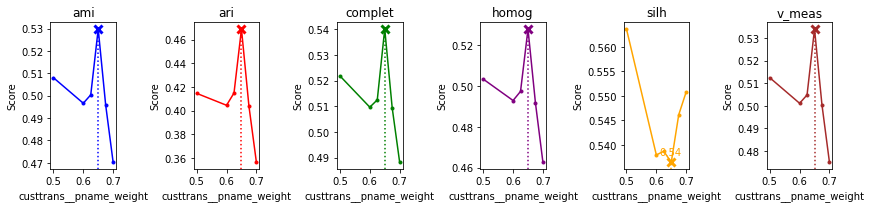

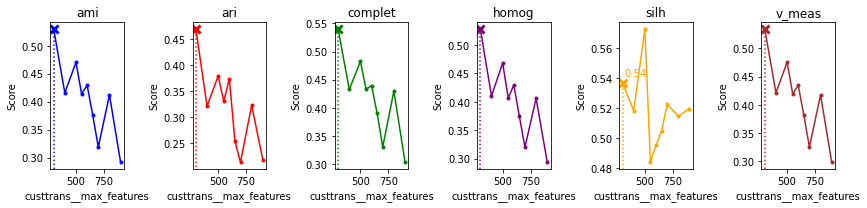

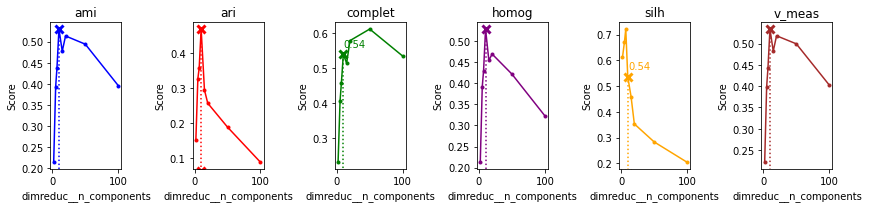

In [ ]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

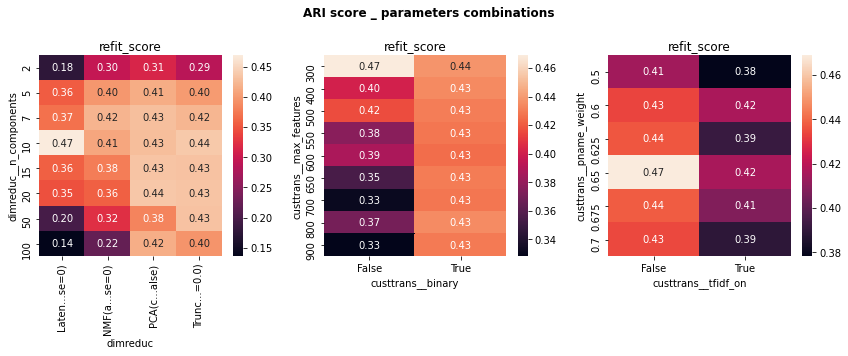

In [ ]:
# Effect of 2 parameters on clustering scores

params1 = ['dimreduc__n_components', 'dimreduc']
params2 = ['custtrans__max_features', 'custtrans__binary']
params3 = ['custtrans__pname_weight', 'custtrans__tfidf_on']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, fmt='.2f',
                          shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, fmt='.2f',
                          shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, fmt='.2f',
                          shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

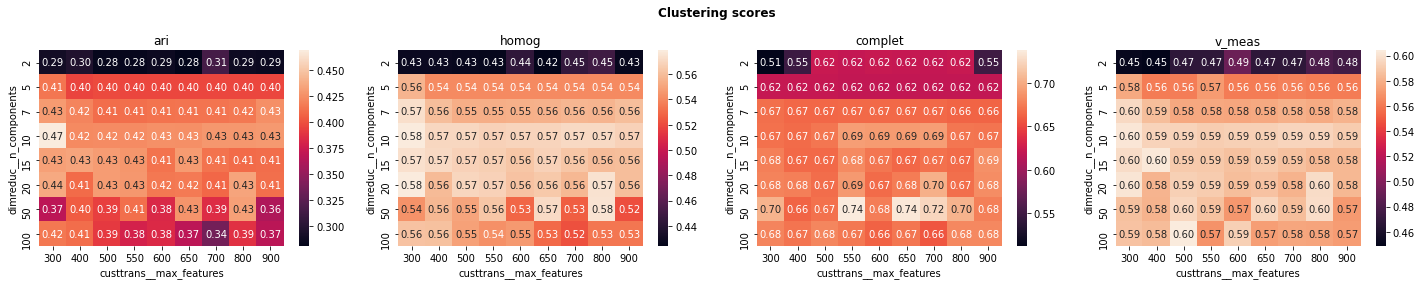

In [ ]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['dimreduc__n_components', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# Storing labels of the best model in a dataframe
df_res_clust['04b_USE_dimred_km'] = \
        gsc.best_estimator_.predict(df_desc_cat[['desc_clean',
                                                        'pname_clean']])

In [ ]:
# Computing the best preprocessed dataset prior to clustering
dict_best_df['04b_USE_dimred_km'] = \
        gsc.best_estimator_.transform(df_desc_cat[['desc_clean',
                                                   'pname_clean']])

In [ ]:
### Pickling the best preprocessed dataset prior to clustering
import dill as pickle
with open('dict_best_df.pkl', 'wb') as file:
    pickle.dump(dict_best_df, file)

## 5 Comparison of clusters labels with true categories

#### Comparison between scores...

In [ ]:
# # Comparison of clusters labels with true categories

# from sklearn.metrics import adjusted_rand_score

# ser_ari_pairs_models = comp_clust_metrics_col_pairs(df_res_clust,
#                                                     first_vs_others=True,
#                                                     print_opt=False,
#                                                     n_score='ari')

# # Plotting the results

# fig = plt.figure(figsize=(3,3))
# ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
# plt.ylabel('ARI score')
# # plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# # plt.gca().set(ylim=(0.85,1))
# plt.show()

#### Matching scores (true categories vs. clusters)

In [122]:
df_res_clust.columns

Index(['categories', '01_preproc_km'], dtype='object')

In [ ]:
ser_pairs_models = comp_clust_metrics_col_pairs(df_res_clust,
                                                first_vs_others=True,
                                                n_score='v_meas',
                                                print_opt=True)

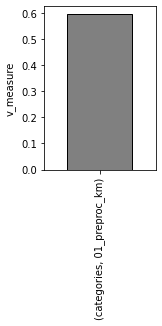

In [125]:
fig = plt.figure(figsize=(2,3))
ser_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('v_measure')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

#### Confusion matrix

In [126]:
cat_clust_confmat = confusion_matrix_clust(df_res_clust['categories'],
                                           df_res_clust['01_preproc_km'],
                                           normalize=False,
                                           margins_sums=True,
                                           margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

01_preproc_km,2,5,6,3,1,0,4,cat_sum,cat_matching_score_pct
categories,,,,,,,,,
Baby,82,40,18,0,9,1,0,150,55
Beauty,0,150,0,0,0,0,0,150,100
Computers,0,150,0,0,0,0,0,150,0
Decor,0,48,1,100,1,0,0,150,67
Furnishing,0,34,33,1,82,0,0,150,55
Kitchen,0,74,0,2,0,74,0,150,49
Watches,0,7,0,0,0,0,143,150,95
clust_sum,82,503,52,103,92,75,143,1050,-
clust_matching_score_pct,100,30,0,97,89,99,100,-,-


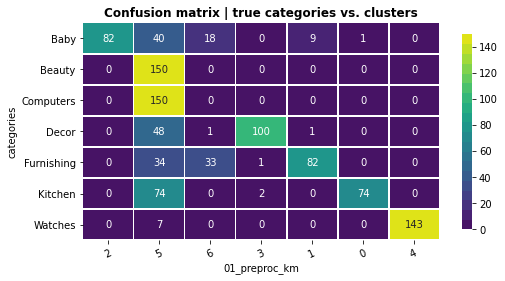

In [128]:
cm = confusion_matrix_clust(df_res_clust['categories'],
                            df_res_clust['01_preproc_km'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
                 palette=sns.color_palette("viridis", 20), shape='rect',
                 fmt='.0f', robust=False, fig=None, ax=None)

####  Sankey confusion diagram

In [136]:
# to get interactive graph
plot_sankey_confusion_mat(cm, static=False, font_size=14)

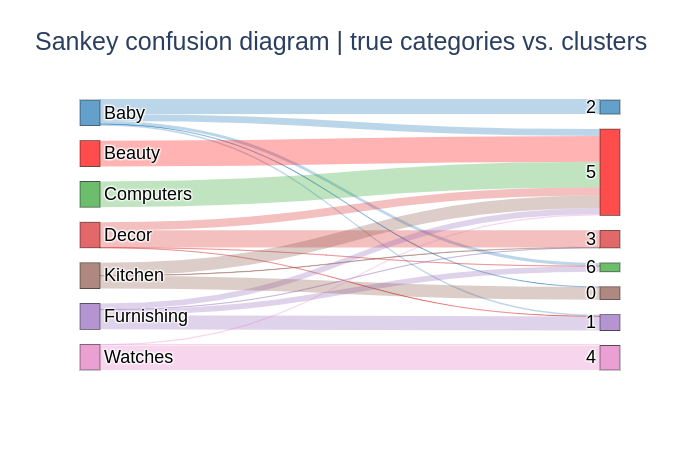

In [129]:
# # to get interactive graph
# plot_sankey_confusion_mat(cm, static=False, font_size=14)

# to get static graph static
import plotly.graph_objects as go
from IPython.display import Image

img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
                                      figsize=(2, 1.7), scale = 1)
Image(img_bytes)

#### 2D visualisation

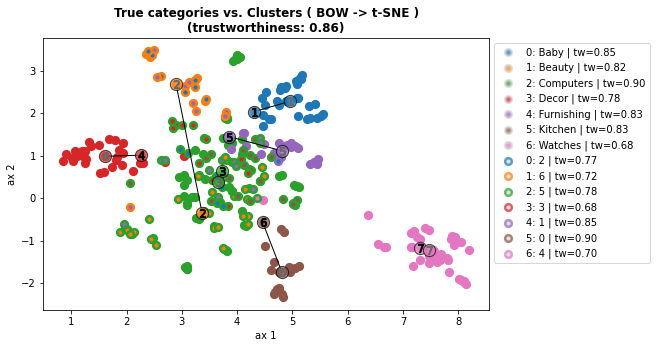

In [144]:
# Plotting a projection of the points (true categories vs. clusters) (PCA 0.71, UMAP 0.81, t-SNE 0.83)

ind_samp = df_res_clust.sample(300, random_state=14).index
plot_projection_cat_clust(dict_best_df['01_preproc_km'].loc[ind_samp], model=None,
                 ser_clust=df_res_clust['01_preproc_km'].loc[ind_samp], # clustering already done
                 true_cat=df_res_clust['categories'].loc[ind_samp], # true categories
                 proj='UMAP', tw_n_neigh=3, 
                 size=45, edgelinesize=2.5, legend_on=True,
                 title="True categories vs. Clusters ( BOW -> t-SNE )",
                 figsize=(8, 5), palette='tab10',
                 fig=None, ax=None, random_state=14, bboxtoanchor=(1,1))

- calcul de la pertinence des catégories trouvées par rapport aux catégories initiales et représentation graphique

- optimisation du nombre de catégories par mesure de la cohérence des mots les plus représentatifs de chaque catégorie (nécessite d'entraîner un modèle word2vec)
- représentation des catégories (des mots les plus représentatifs qui les composent) avec t-SNE
- essai direct de clustering sur la représentation des mots par Word2Vec

- Latent Dirichlet Allocation pour trouver d'autres clusters

- comment mettre en place un vote permettant d'aggréger le résultat de plusieurs clusterings différents lorsque les catégories n'ont pas les mêmes numéros ? 